In [189]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists

In [190]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [4]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9086


In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(token_values)

print(X.shape)

Processing TF-IDF
(9086, 141273)


In [6]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [7]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [8]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['keywords'] = top_feats_in_doc(X, vectorizer.get_feature_names(), i, 10)
    
print(docs['2016-05-20-28']['keywords'])

   feature     tfidf
0     bull  0.337933
1   soccer  0.239934
2      red  0.209805
3     citi  0.193355
4  glidden  0.188261
5      nyc  0.183386
6       fc  0.167634
7   jersey  0.164249
8       ml  0.163835
9      fan  0.160802


In [9]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [5]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

# Build the graph from scratch

In [6]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9086


In [10]:
g.delete_edges(g.es)
edges = []
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for i_2, key_2 in enumerate(token_keys):
        edges.append((key, key_2))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

82555396


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, key in enumerate(token_keys):
    similarities = cosine_similarity(X[i], X)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for i_2, key_2 in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[i_2]
        count += 1

print(g.ecount())

82555396


Remove duplicated and self-loop edges

In [13]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41273155


In [14]:
g.es[1]['weight']

0.027366185195034684

In [15]:
g.write_gml('tmp/igraph.gml')

In [65]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/igraph_01.gml'

In [16]:
g.es[1].tuple

(0, 2)

In [17]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x10e1f0d68>, 0, {'name': '2016-05-01-1'})

In [73]:
sub_g = g.es.select(weight_ge=0).subgraph()

In [75]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))
# print("Diameter {}".format(sub_g.diameter()))
# print("LCC {}".format(sub_g.clusters().giant().vcount()))
# print("APL {}".format(sub_g.average_path_length()))
print("AD {}".format(sum(sub_g.degree())/len(sub_g.degree())))

Nodes 9086
Edges 41273155
AD 9085.0


In [26]:
sub_g.es()[0].tuple

(0, 1734)

In [23]:
print(sub_g.vs[1])
print(sub_g.vs[3])

igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 0, {'name': '2016-05-01-122'})
igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 3, {'name': '2016-05-01-81'})


In [39]:
sub_g.write_gml('tmp/subgraph_01.gml')

# Load Network

In [365]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [366]:
sg = g.es.select(weight_ge=0.2).subgraph()

In [367]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [368]:
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("Diameter {}".format(sg.diameter()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("APL {}".format(sg.average_path_length()))
print("AD {}".format(sum(sg.degree())/len(sg.degree())))
print("Giant Size {}".format(len(community.giant().vs())))
print("NO of Communities {}".format(max(community.membership)))
print("Modularity {}".format(sg.modularity(community.membership)))

Nodes 7814
Edges 98164
Diameter 15
LCC 7356
APL 5.104654144972761
AD 25.125159969285896
Giant Size 612
NO of Communities 226
Modularity 0.8243999357460129


In [212]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership)):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Size Chart

In [235]:
net_topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            net_topics[topic_no]
        except KeyError:
            net_topics[topic_no] = 0

        net_topics[topic_no] += 1 
        
len(net_topics.keys())

1497

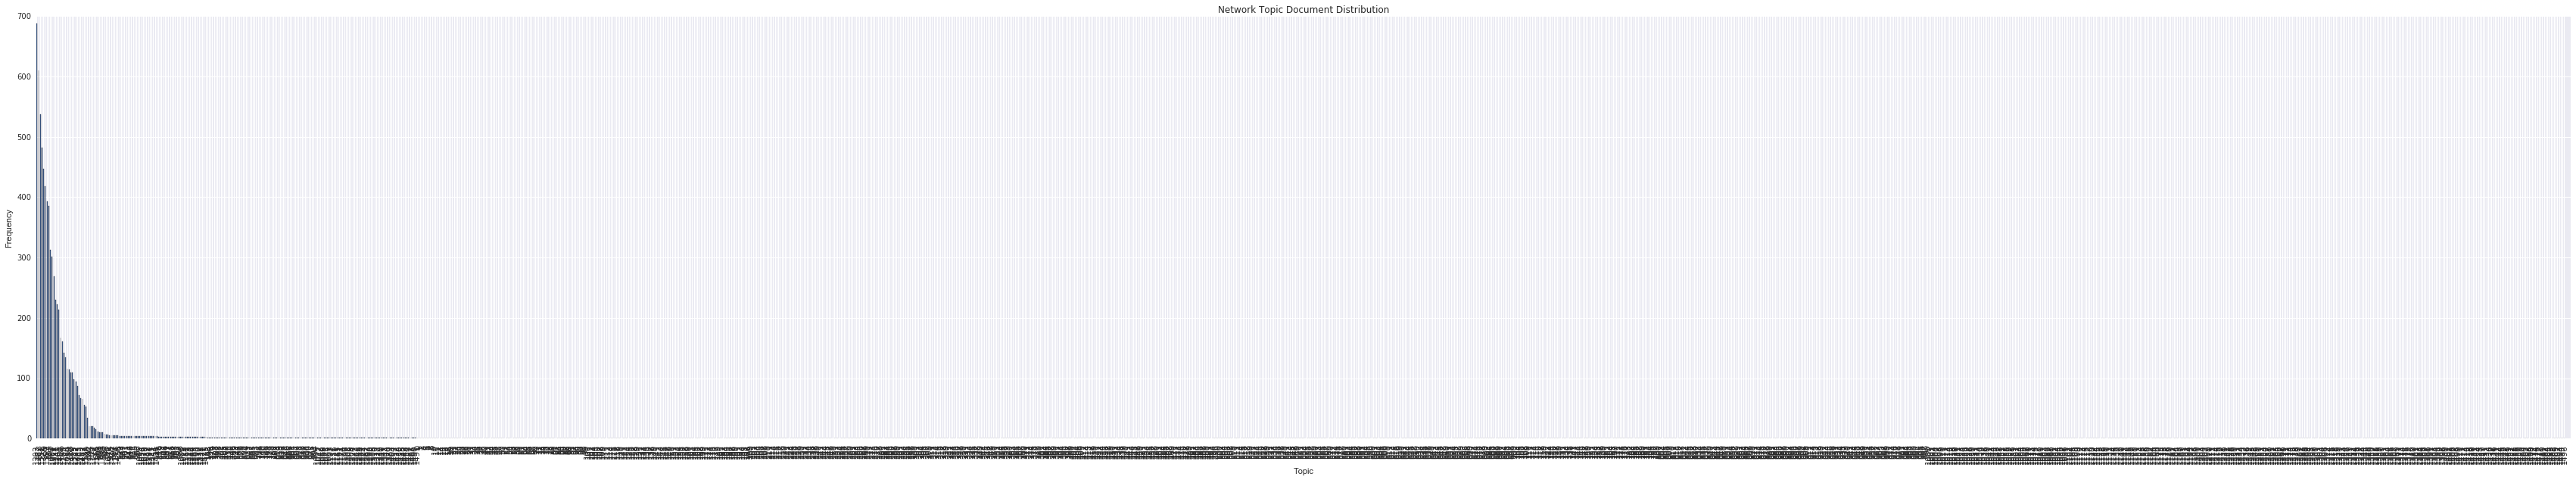

In [236]:
x_data = []
y_data = []
for key, value in sorted(net_topics.items(), key=lambda x: x[1], reverse=True):
    x_data.append(key)
    y_data.append(value)

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Network Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_net.png')
plt.show()

# LDA

In [14]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(token_values)
vocab = vectorizer.get_feature_names()

print(X.shape)

(9086, 141273)


In [86]:
np.random.seed(1234)

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

gensim_model = LdaModel(matutils.Sparse2Corpus(X.T), 
                num_topics=226,
                passes=50,
                id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [87]:
pickle.dump(gensim_model, open('tmp/gensim_lda.pickle', 'wb'))

# Load LDA

In [15]:
lda_model = pickle.load(open('tmp/gensim_lda.pickle', 'rb'))

In [18]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X.T)]
print(len(doc_topic_prob_mat))

9086


In [20]:
for i, mat in enumerate(doc_topic_prob_mat):
    docs[token_keys[i]]['topic_most_pr'] = max(mat, key=lambda x: x[1])[0]

lda_items = sorted(docs.items(), key=lambda x: x[1]['topic_most_pr'])

In [21]:
pickle.dump(lda_items, open('tmp/lda_items.pickle', 'wb'))

In [22]:
pickle.dump(docs, open('tmp/docs_topic_most_pr.pickle', 'wb'))

In [23]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['topic_most_pr'], item[0], item[1]['webTitle']))

In [ ]:
lda_items = pickle.load(open('tmp/lda_items.pickle', 'rb'))

# Size Chart

In [43]:
lda_topics = {}

for i in range(226):
    lda_topics[i] = []
    
for item in lda_items:
    topic_no = item[1]['topic_most_pr']
    lda_topics[topic_no].append(item[0])
    
len(lda_topics.keys())

226

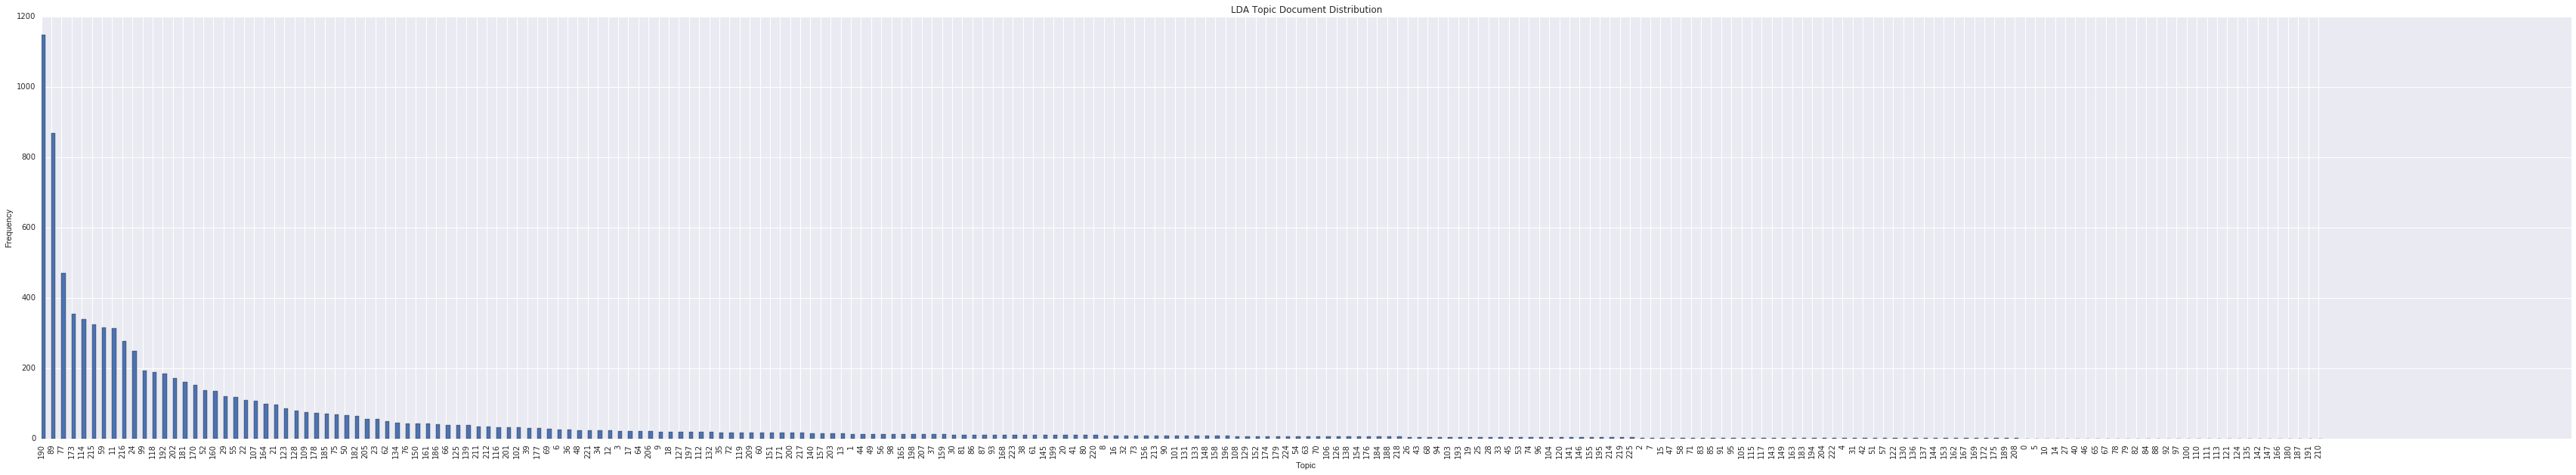

In [72]:
x_data = []
y_data = []
for key, value in sorted(lda_topics.items(), key=lambda x: len(x[1]), reverse=True):
    x_data.append(key)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("LDA Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

# Heatmap

In [369]:
topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(v['name'])

net_data = []
for key, value in sorted(topics.items(), key=lambda x: x[0]):
    h = {}
    for v in value:
        h[v] = True
    net_data.append(h)
        
print(len(net_data))
print(net_data[0])

226
{'2016-05-01-3': True, '2016-05-02-13': True}


In [47]:
topics = {}

topics = lda_topics
    
lda_data = []
for key, value in sorted(topics.items(), key=lambda x: x[0]):
    h = {}
    for v in value:
        h[v] = True
    lda_data.append(h)

print(len(lda_data))
print(lda_data[1])

226
{'2016-05-13-44': True, '2016-05-27-195': True, '2016-05-19-9': True, '2016-05-13-266': True, '2016-05-19-190': True, '2016-05-20-24': True, '2016-05-19-60': True, '2016-05-14-142': True, '2016-05-13-331': True, '2016-05-25-267': True, '2016-05-20-98': True, '2016-05-18-63': True, '2016-05-13-143': True}


In [407]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = net_data + lda_data
X = vectorizer.fit_transform(vectors)

print(X.shape)

(452, 9086)


In [408]:
print(len(net_data[0].keys()))
print(len(lda_data[0].keys()))
print(np.count_nonzero(X[:226].toarray()[0]))

2
0
2


In [409]:
net_vectors = X[:226]
lda_vectors = X[226:]

In [410]:
similarities = cosine_similarity(net_vectors, lda_vectors)

In [412]:
np.savetxt('tmp/heatmap.csv', similarities, fmt='%d', delimiter=",")

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

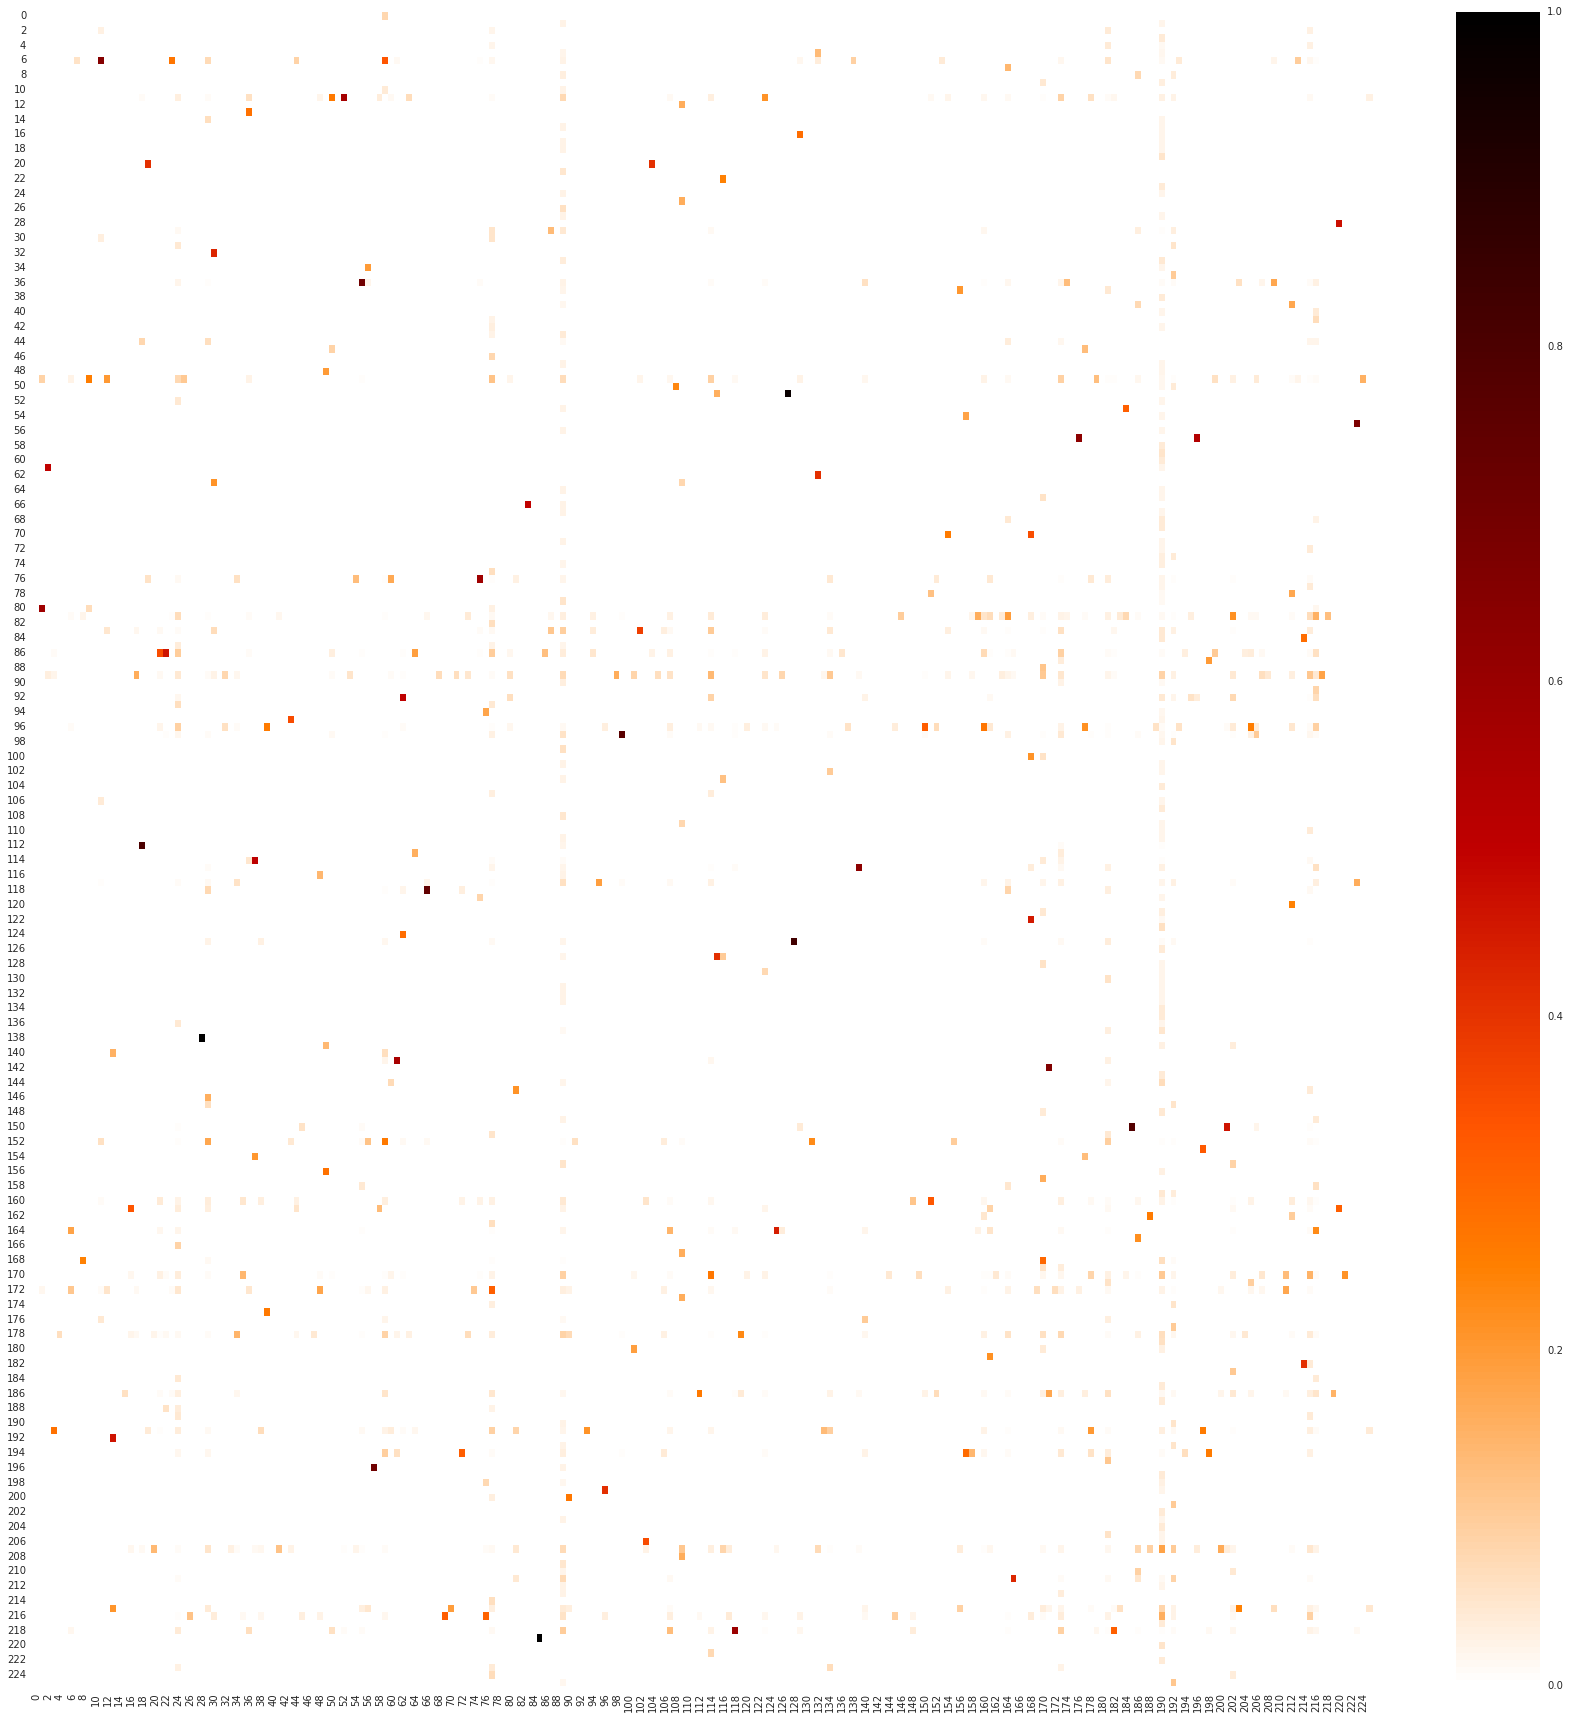

In [413]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarities, xticklabels=2, yticklabels=2, cmap=plt.cm.gist_heat_r)

# Size to topic table + keywords

In [147]:
import itertools

def save_keyword_table(topics, file_path):
    result = {}
    rows = []
    for topic in topics:
        items = list(map(lambda x: x.values.tolist(), topic[1]))
        keywords = sorted(list(itertools.chain(*items)), key=lambda x: x[1], reverse=True)
        keywords = list(map(lambda x: x[0], keywords))[:10]
        result[topic[0]] = (len(topic[1]), keywords)
        rows.append([topic[0], len(topic[1]), keywords])

    with open(file_path, 'w+') as file:
        for row in rows:
            file.write("{};{};{}\n".format(row[0], row[1], row[2]))
    
    return result

In [148]:
topics = {}

for i in range(max(community.membership)):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(docs[v['name']]['keywords'])
        
topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

net_keywords = save_keyword_table(topics, 'tmp/keywordtable_net.csv')

In [149]:
topics = {}

for k, v in lda_items:
    topic_no = v['topic_most_pr']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['keywords'])
    
topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

lda_keywords = save_keyword_table(topics, 'tmp/keywordtable_lda.csv')

In [77]:
list_of_menuitems = list(map(lambda x: x.values.tolist(), topics[6][1]))
chain = sorted(list(itertools.chain(*list_of_menuitems)), key=lambda x: x[1], reverse=True)
print(chain[:20])

[['kooiman', 0.8127769719535584], ['schipper', 0.7495957471079563], ['pite', 0.7094665105009573], ['knox', 0.7019186599186819], ['itoj', 0.6980839430275991], ['curri', 0.6894071166736933], ['warnock', 0.6861303977937785], ['raptor', 0.683898791026874], ['ebner', 0.6837088357276689], ['arteta', 0.6759196190401957], ['netbal', 0.6552455601214872], ['quidditch', 0.6547345488243379], ['bradford', 0.6473911018945802], ['hayn', 0.6457407443257588], ['iceland', 0.6448972880254444], ['spur', 0.6448155891426471], ['morri', 0.6290075384655391], ['curri', 0.6260469208663165], ['suárez', 0.6258813560860709], ['spieth', 0.623562434424801]]


In [129]:
a = similarities[6].toarray()[0]
m = max(range(len(a)), key=lambda x: a[x])
m

11

In [146]:
import csv
with open('tmp/matching.csv', 'w+') as file:
    rows = []
    for i, row in enumerate(similarities):
        a = row.toarray()[0]
        lda =  max(range(len(a)), key=lambda x: a[x])
        sim =  max(a)
        rows.append([i, net_keywords[i][0], net_keywords[i][1], lda, lda_keywords[lda][0], lda_keywords[lda][1], sim])
    
    for row in sorted(rows, key=lambda x: x[1], reverse=True):
        writer = csv.writer(file)
        writer.writerow(row)

# LDA + Modularity

In [424]:
membership = []
for v in sg.vs():
    membership.append(docs[v['name']]['topic_most_pr'])

print("Network Communities Modularity {}".format(sg.modularity(community.membership)))
print("LDA Communities Modularity {}".format(sg.modularity(membership)))

Network Communities Modularity 0.8243999357460129
LDA Communities Modularity 0.4235280324048751


# Modularity applied to LDA Similarities

In [287]:
lda_model.minimum_probability=0.0

mat = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    progress = i/len(token_keys)
    print('{0}\r'.format(progress))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat.append(a)

0.9998899405679067


In [288]:
len(mat)

9086

In [417]:
mat = np.mat(mat)
pickle.dump(mat, open('tmp/mat3.pickle', 'wb'))
mat_np[1]

matrix([[ 0.        ,  0.        ,  0.01226318,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.02008254,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.03434723,
          0.        ,  0.        ,  0.        ,  0.        ,  0.01441289,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.01745501,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.

In [298]:
len(cosine_similarity(mat_np[0], mat_np)[0])

9086

In [292]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9086


In [302]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for i_2, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

82555396


In [303]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    similarities = cosine_similarity(mat_np[i], mat_np)[0]
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

0.9998899405679067
82555396


In [304]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41273155


In [305]:
g.write_gml('tmp/igraph_lda.gml')

In [311]:
sg = g.es.select(weight_ge=0.1).subgraph()

In [312]:
sg.write_gml('tmp/igraph_lda_01.gml')

In [ ]:
g = ig.Graph.Read_GML('tmp/igraph_lda_01.gml')

In [ ]:
sg = g.es.select(weight_ge=0.9).subgraph()

In [ ]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [ ]:
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("Diameter {}".format(sg.diameter()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("APL {}".format(sg.average_path_length()))
print("AD {}".format(sum(sg.degree())/len(sg.degree())))
print("Giant Size {}".format(len(community.giant().vs())))
print("NO of Communities {}".format(max(community.membership)))
print("Modularity {}".format(sg.modularity(community.membership)))

In [352]:
with open('tmp/lda_network_docs.txt', 'w+') as file:
    for i in range(max(community.membership)):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))